In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_Q5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Mar 27 03:16:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 39%   51C    P0    35W / 370W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 67%   

In [12]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_Q5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 238.5MiB
TTS size 150.9MiB
MelEncoder size 44.0MiB
MelDecoder size 85.6MiB
0
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.034516191482543944


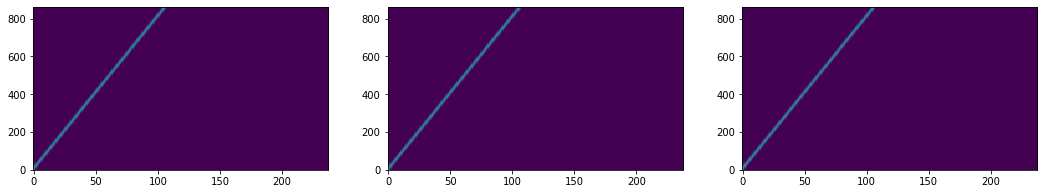

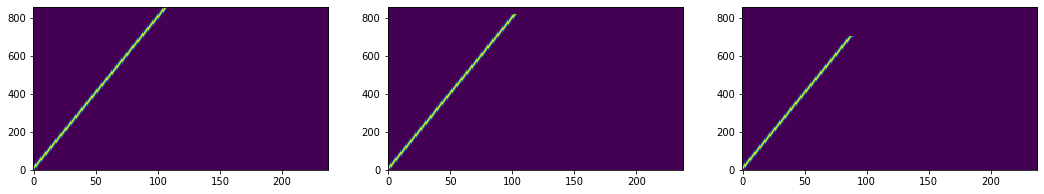

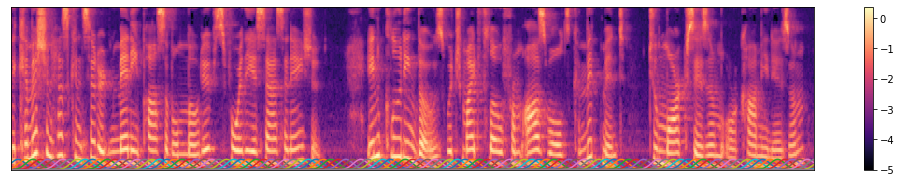

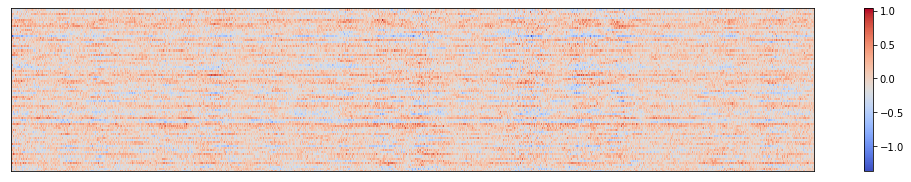

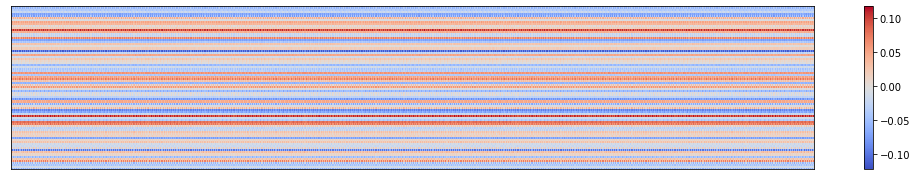

tensor(5.8806, device='cuda:0')
step : 1 stt : 5.5037 tts : 15.3454 recon : 13.8926 kl : 0.0868 beta : 0.0000
tensor(5.6946, device='cuda:0')
step : 2 stt : 5.4662 tts : 13.5891 recon : 12.1430 kl : 0.0889 beta : 0.0001
tensor(5.7713, device='cuda:0')
step : 3 stt : 5.4248 tts : 13.3307 recon : 11.9094 kl : 0.0892 beta : 0.0001
tensor(6.5087, device='cuda:0')
step : 4 stt : 5.3723 tts : 13.2627 recon : 11.8597 kl : 0.0915 beta : 0.0001
tensor(7.3069, device='cuda:0')
step : 5 stt : 5.3149 tts : 13.6794 recon : 12.1155 kl : 0.0975 beta : 0.0001
tensor(7.0990, device='cuda:0')
step : 6 stt : 5.2400 tts : 12.2625 recon : 10.8892 kl : 0.1051 beta : 0.0001
tensor(8.3379, device='cuda:0')
step : 7 stt : 5.1260 tts : 12.9121 recon : 11.4693 kl : 0.1169 beta : 0.0002
tensor(8.8245, device='cuda:0')
step : 8 stt : 5.0239 tts : 12.0327 recon : 10.4641 kl : 0.1284 beta : 0.0002
tensor(9.6417, device='cuda:0')
step : 9 stt : 4.8274 tts : 10.7286 recon : 9.4356 kl : 0.1408 beta : 0.0002
tensor(10.2

tensor(3.2419, device='cuda:0')
step : 76 stt : 1.9630 tts : 1.6242 recon : 0.1566 kl : 0.4624 beta : 0.0015
tensor(2.3518, device='cuda:0')
step : 77 stt : 1.9516 tts : 1.5508 recon : 0.1644 kl : 0.4796 beta : 0.0016
tensor(2.1376, device='cuda:0')
step : 78 stt : 1.8159 tts : 1.5495 recon : 0.1576 kl : 0.4562 beta : 0.0016
tensor(1.9335, device='cuda:0')
step : 79 stt : 1.8793 tts : 1.5529 recon : 0.1483 kl : 0.4556 beta : 0.0016
tensor(1.9061, device='cuda:0')
step : 80 stt : 1.9448 tts : 1.5487 recon : 0.1519 kl : 0.4746 beta : 0.0016
tensor(1.7270, device='cuda:0')
step : 81 stt : 1.6886 tts : 1.5188 recon : 0.1438 kl : 0.4582 beta : 0.0016
tensor(1.7934, device='cuda:0')
step : 82 stt : 1.5815 tts : 1.5326 recon : 0.1380 kl : 0.4403 beta : 0.0017
tensor(1.9222, device='cuda:0')
step : 83 stt : 1.8134 tts : 1.5537 recon : 0.1424 kl : 0.4538 beta : 0.0017
tensor(1.9726, device='cuda:0')
step : 84 stt : 1.7395 tts : 1.5270 recon : 0.1508 kl : 0.4537 beta : 0.0017
tensor(1.9949, devi

tensor(1.6742, device='cuda:0')
step : 151 stt : 1.4696 tts : 0.9048 recon : 0.1034 kl : 0.4917 beta : 0.0030
tensor(1.7378, device='cuda:0')
step : 152 stt : 1.4673 tts : 0.8997 recon : 0.1033 kl : 0.4855 beta : 0.0031
tensor(1.7708, device='cuda:0')
step : 153 stt : 1.2876 tts : 0.9439 recon : 0.0997 kl : 0.4754 beta : 0.0031
tensor(1.5848, device='cuda:0')
step : 154 stt : 1.3601 tts : 0.9054 recon : 0.0964 kl : 0.4765 beta : 0.0031
tensor(1.9507, device='cuda:0')
step : 155 stt : 1.4017 tts : 0.9188 recon : 0.1091 kl : 0.4798 beta : 0.0031
tensor(1.5926, device='cuda:0')
step : 156 stt : 1.2231 tts : 0.9144 recon : 0.0955 kl : 0.4756 beta : 0.0031
tensor(1.5730, device='cuda:0')
step : 157 stt : 1.3083 tts : 0.9158 recon : 0.0972 kl : 0.4783 beta : 0.0032
tensor(1.6354, device='cuda:0')
step : 158 stt : 1.3504 tts : 0.8722 recon : 0.1020 kl : 0.4869 beta : 0.0032
tensor(1.8106, device='cuda:0')
step : 159 stt : 1.3693 tts : 0.8868 recon : 0.1121 kl : 0.5019 beta : 0.0032
tensor(1.6

tensor(2.0041, device='cuda:0')
step : 226 stt : 1.0524 tts : 0.7577 recon : 0.0946 kl : 0.4609 beta : 0.0045
tensor(1.8701, device='cuda:0')
step : 227 stt : 1.2238 tts : 0.7577 recon : 0.0895 kl : 0.4618 beta : 0.0046
tensor(2.7165, device='cuda:0')
step : 228 stt : 1.1303 tts : 0.7395 recon : 0.0885 kl : 0.4651 beta : 0.0046
tensor(2.1458, device='cuda:0')
step : 229 stt : 1.1715 tts : 0.7370 recon : 0.1007 kl : 0.4659 beta : 0.0046
tensor(1.6816, device='cuda:0')
step : 230 stt : 1.2026 tts : 0.7532 recon : 0.0923 kl : 0.4642 beta : 0.0046
tensor(2.0182, device='cuda:0')
step : 231 stt : 1.0528 tts : 0.8681 recon : 0.0846 kl : 0.4678 beta : 0.0046
tensor(1.5522, device='cuda:0')
step : 232 stt : 1.0461 tts : 0.8578 recon : 0.0916 kl : 0.4656 beta : 0.0047
tensor(1.5164, device='cuda:0')
step : 233 stt : 1.1289 tts : 0.8305 recon : 0.0805 kl : 0.4728 beta : 0.0047
tensor(1.4112, device='cuda:0')
step : 234 stt : 1.1167 tts : 0.8321 recon : 0.0852 kl : 0.4755 beta : 0.0047
tensor(1.4

tensor(2.1985, device='cuda:0')
step : 301 stt : 0.9219 tts : 0.7734 recon : 0.0798 kl : 0.4496 beta : 0.0060
tensor(3.9784, device='cuda:0')
step : 302 stt : 1.0160 tts : 0.7316 recon : 0.1108 kl : 0.4481 beta : 0.0061
tensor(2.4308, device='cuda:0')
step : 303 stt : 0.9364 tts : 0.7410 recon : 0.0911 kl : 0.4513 beta : 0.0061
tensor(2.0335, device='cuda:0')
step : 304 stt : 1.0540 tts : 0.7146 recon : 0.1050 kl : 0.4485 beta : 0.0061
tensor(3.8297, device='cuda:0')
step : 305 stt : 1.0453 tts : 0.7034 recon : 0.0958 kl : 0.4481 beta : 0.0061
tensor(3.4604, device='cuda:0')
step : 306 stt : 0.9561 tts : 0.7536 recon : 0.0961 kl : 0.4451 beta : 0.0061
tensor(4.5034, device='cuda:0')
step : 307 stt : 1.0403 tts : 0.7375 recon : 0.1119 kl : 0.4453 beta : 0.0062
tensor(2.9536, device='cuda:0')
step : 308 stt : 1.0399 tts : 0.7432 recon : 0.1166 kl : 0.4432 beta : 0.0062
tensor(3.0436, device='cuda:0')
step : 309 stt : 1.0793 tts : 0.6916 recon : 0.1060 kl : 0.4414 beta : 0.0062
tensor(1.5

tensor(4.0605, device='cuda:0')
step : 376 stt : 0.9398 tts : 0.6702 recon : 0.0786 kl : 0.4133 beta : 0.0075
tensor(2.2766, device='cuda:0')
step : 377 stt : 1.1236 tts : 0.5731 recon : 0.0858 kl : 0.4111 beta : 0.0076
tensor(3.0039, device='cuda:0')
step : 378 stt : 0.8832 tts : 0.6784 recon : 0.0692 kl : 0.4121 beta : 0.0076
tensor(2.4479, device='cuda:0')
step : 379 stt : 1.0043 tts : 0.5818 recon : 0.0743 kl : 0.4071 beta : 0.0076
tensor(5.6383, device='cuda:0')
step : 380 stt : 1.0338 tts : 0.5887 recon : 0.0760 kl : 0.4048 beta : 0.0076
tensor(10.9828, device='cuda:0')
step : 381 stt : 0.9870 tts : 0.6250 recon : 0.0793 kl : 0.4029 beta : 0.0076
tensor(7.8728, device='cuda:0')
step : 382 stt : 0.8703 tts : 0.6627 recon : 0.0759 kl : 0.4078 beta : 0.0077
tensor(1.4538, device='cuda:0')
step : 383 stt : 0.9428 tts : 0.5609 recon : 0.0760 kl : 0.4047 beta : 0.0077
tensor(3.2845, device='cuda:0')
step : 384 stt : 1.0359 tts : 0.5127 recon : 0.0717 kl : 0.4082 beta : 0.0077
tensor(5.

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [67]:
logger.save(step, model, optimizer)

saved save/model_W5G/save_386768


The earliest book printed with movable type, the aforesaid Gutenberg Bible, is printed in letters which are an exact imitation
torch.Size([1, 80, 708]) 0.03781898021697998
{'alignment': 0.0003094673156738281, 'random': 0.0017800331115722656, 'last_conv': 0.026863813400268555, 'z_proj': 0.000659942626953125, 'cond': 0.0009357929229736328, 'up': 0.0011742115020751953, 'encode': 0.004072427749633789, 'pad': 2.6464462280273438e-05, 'enc_conv': 0.0008444786071777344, 'enc_lstm': 0.003042936325073242}


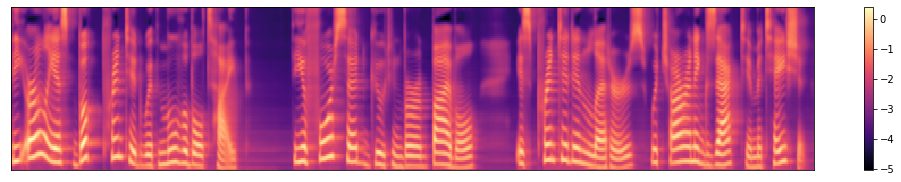

In [65]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 20:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [66]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(181248,)


['F', 'AO1', 'R', ' ', 'AO2', 'L', 'DH', 'OW1', ' ', 'DH', 'AH0', ' ', 'CH', 'AY0', 'N', 'IY1', 'Z', ' ', 'T', 'UH1', 'K', ' ', 'IH0', 'M', 'P', 'R', 'EH1', 'SH', 'AH0', 'N', 'Z', ' ', 'F', 'R', 'AH1', 'M', ' ', 'W', 'UH1', 'D', ' ', 'B', 'L', 'AA1', 'K', 'S', ' ', 'IH0', 'N', 'G', 'R', 'EY1', 'V', 'D', ' ', 'IH0', 'N', ' ', 'R', 'IH0', 'L', 'IY1', 'F', ' ', 'F', 'AO1', 'R', ' ', 'S', 'EH1', 'N', 'CH', 'ER0', 'IY0', 'Z', ' ', 'B', 'IH0', 'F', 'AO1', 'R', ' ', 'DH', 'AH0', ' ', 'W', 'UH1', 'D', 'K', 'AH2', 'T', 'ER0', 'Z', ' ', 'AH1', 'V', ' ', 'DH', 'AH0', ' ', 'N', 'EH1', 'DH', 'ER0', 'L', 'AH0', 'N', 'D', 'Z', ' ', ',', ' ', 'B', 'AY1', ' ', 'AH0', ' ', 'S', 'IH1', 'M', 'AH0', 'L', 'ER0', ' ', 'P', 'R', 'AA1', 'S', 'EH2', 'S', ' ', '.']


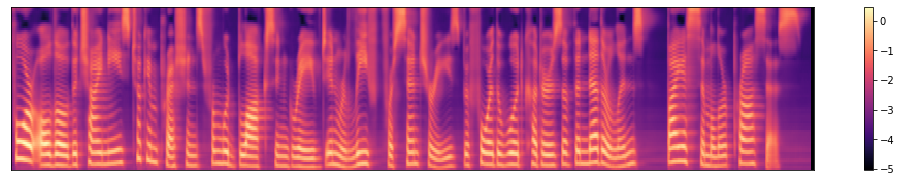

(199424,)


In [32]:
from g2p_en import G2p

g2p = G2p()
text = "For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process."
text_array = g2p(text)
print(text_array)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():

    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)